In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import astropy.constants as aconst
from calcwf import const_eff_chirp_bose, const_eff_chirp_favata, chirp2total

In [2]:
e_vals = np.linspace(0,0.2,100)
chirp_vals_b = const_eff_chirp_bose(0.1, 24, e_vals)
chirp_vals_f = const_eff_chirp_favata(0.1, 24, e_vals, average_f=False)

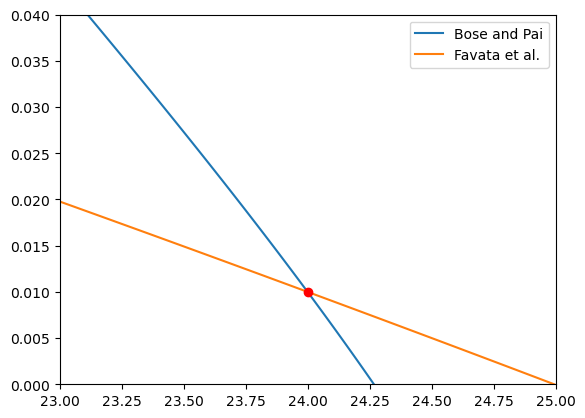

In [3]:
plt.plot(chirp_vals_b, e_vals**2, label='Bose and Pai')
plt.plot(chirp_vals_f, e_vals**2, label='Favata et al.')
plt.scatter(24, 0.1**2, c='r', zorder=5)
plt.xlim(23,25)
plt.ylim(0,0.04)
plt.legend()

Neither line is able to describe the degeneracy we find in our e^2 against chirp mass plots well. We will try to calculate a weighted average of the frequency, and evolve the ecccentricity to this stage in order to input into the favata et al. equation. Can do this by defining:

\begin{equation}
\overline{f} = \frac{4 \Re \int df \frac{f |h(f)|^2}{S(f)}}{4 \Re \int df \frac{|h(f)|^2}{S(f)}} = \frac{\int df \frac{f |h(f)|^2}{S(f)}}{\int df \frac{|h(f)|^2}{S(f)}}
\end{equation}
This can be achieved with the sigmasq function of pycbc: first inputting $h(f)$ to get the denominator, and then $\sqrt{f}\cdot h(f)$ for the numerator. We can then translate eccentricities we input into the favata et al. function from $e(f_{10})$ to $e(\overline{f})$, and see whether this improves the resulting degeneracy line.

In [4]:
chirp_vals_avg_f = const_eff_chirp_favata(0.1, 24, e_vals, f_low=10, q=2, average_f=True)

Average frequency: 82.71992022152772 Hz
Given_e shifted from 0.1 to 0.010750076475934445


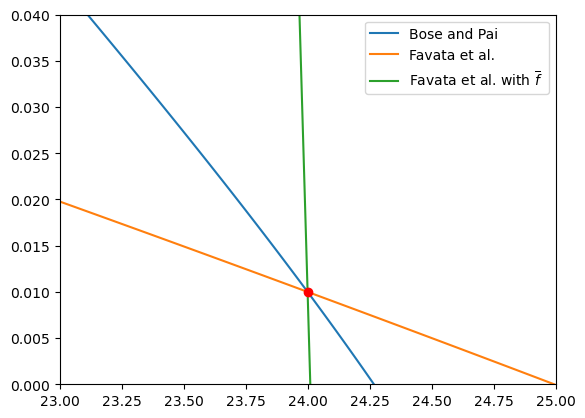

In [5]:
plt.plot(chirp_vals_b, e_vals**2, label='Bose and Pai')
plt.plot(chirp_vals_f, e_vals**2, label='Favata et al.')
plt.plot(chirp_vals_avg_f, e_vals**2, label='Favata et al. with $\overline{f}$')
plt.scatter(24, 0.1**2, c='r', zorder=5)
plt.xlim(23,25)
plt.ylim(0,0.04)
plt.legend()

Would the orbit actually evolve to this high of a frequency of 83Hz? Innermost stable circular orbit of a black hole is at $r_{\mathrm{ISCO}} = 6M$, so assume merger happens here. Can find gravitational wave frequency as twice the orbital frequency at this radius.

In [6]:
r_isco = 6*const.G*chirp2total(24,2)*aconst.M_sun.value/const.c**2
orb_period = np.sqrt((4*np.pi**2*r_isco**3)/(const.G*chirp2total(24,2)*aconst.M_sun.value))
f_gw = 2/orb_period
print(f_gw)

74.30789804011728


It is very close so do not trust the equation I have used to evolve the eccentricity this high - additionally believe it is only accurate for small changes in eccentricity/frequency which is clearly not the case here.

From Maggiore (page 187), we have:

\begin{equation}
\frac{da}{de} = \frac{12}{19} a \frac{1+(73/24)e^2+(37/96)e^4}{e(1-e^2)[1+(121/304)e^2]}
\end{equation}

which when integrated analytically gives

\begin{equation}
a(e) = c_0\frac{e^{12/19}}{1-e^2} \left(1+\frac{121}{304}e^2 \right)^{870/2299}
\end{equation}

Changing from $a(e)$ to $f_{\mathrm{GW}}$, we get

\begin{equation}
f_{GW} = d_0 \frac{(1-e^2)^{3/2}}{e^{18/19}} \left(1+\frac{121}{304}e^2 \right)^{-1305/2299}
\end{equation}

By taylor expanding around $e \ll 1$, we recover the familiar equation that we had been using

\begin{equation}
e = e_0 \left(\frac{f_{\mathrm{GW}}}{f_0} \right)^{-19/18}
\end{equation}

Will therefore try the exact equation to evolve the frequency. Obviously cannot solve for $e$ here, so will use optimisation with scipy again.

In [7]:
chirp_vals_exact_f = const_eff_chirp_favata(0.1, 24, e_vals, f_low=10, q=2, average_f=True, shift_e='exact')

Average frequency: 82.71992022152772 Hz
Given_e shifted from 0.1 to [0.01094614]


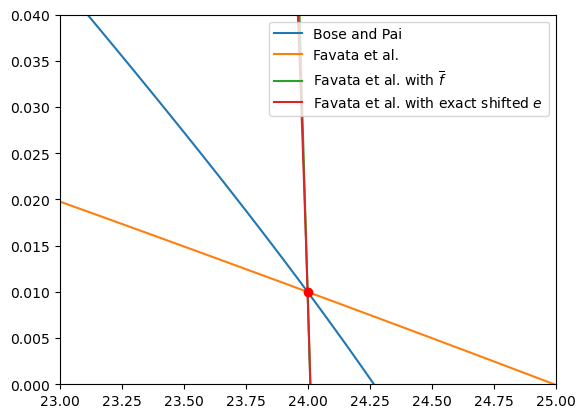

In [8]:
plt.plot(chirp_vals_b, e_vals**2, label='Bose and Pai')
plt.plot(chirp_vals_f, e_vals**2, label='Favata et al.')
plt.plot(chirp_vals_avg_f, e_vals**2, label='Favata et al. with $\overline{f}$')
plt.plot(chirp_vals_exact_f, e_vals**2, label='Favata et al. with exact shifted $e$')
plt.scatter(24, 0.1**2, c='r', zorder=5)
plt.xlim(23,25)
plt.ylim(0,0.04)
plt.legend()

This makes almost negligible difference to shape of line, so has no advantage over the more approximate equation. Furthermore, I still doubt the validity of the equation as it is shifting to above the ISCO frequency.

Another idea I want to try is to set upper bound of integral when calculating $\overline{f}$ to the ISCO frequency. Will use the following equation (cleaned up/simplified version of code above):

\begin{equation}
f_{\mathrm{ISCO}} = \frac{1}{6\sqrt{6}\pi}\frac{c^3}{Gm}
\end{equation}

In [9]:
chirp_vals_ISCO_upper_f = const_eff_chirp_favata(0.1, 24, e_vals, f_low=10, q=2, average_f=True, ISCO_upper=True)

Average frequency: 42.52521765110796 Hz
Given_e shifted from 0.1 to 0.021698446760048763


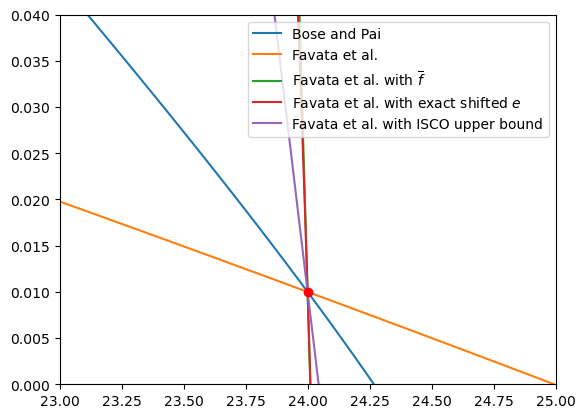

In [10]:
plt.plot(chirp_vals_b, e_vals**2, label='Bose and Pai')
plt.plot(chirp_vals_f, e_vals**2, label='Favata et al.')
plt.plot(chirp_vals_avg_f, e_vals**2, label='Favata et al. with $\overline{f}$')
plt.plot(chirp_vals_exact_f, e_vals**2, label='Favata et al. with exact shifted $e$')
plt.plot(chirp_vals_ISCO_upper_f, e_vals**2, label='Favata et al. with ISCO upper bound')
plt.scatter(24, 0.1**2, c='r', zorder=5)
plt.xlim(23,25)
plt.ylim(0,0.04)
plt.legend()

This is closer but still not quite right. I could likely keep on going making 'random' changes until I get something that looks right, however has no physical justification/basis, and would likely not work for other parameters. I believe that the problem with the current $\overline{f}$ may be twofold. Firstly, as previously explored, $\overline{f} > f_{\mathrm{ISCO}}$, and so the orbital evolution equation cannot be used to calculate the corresponding eccentricity. Secondly, the power in the signal at each frequency may not necessarily uniquely determine the ability to differentiate eccentricity and chirp mass - it is possible that different phases of the signal may give more or less information in this regard, so this may not be quite the right metric to weight by when calculating $\overline{f}$.